In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
ad = sc.read_h5ad("AML3.decipher.post-analyzed.h5ad")

In [21]:
sc.pp.calculate_qc_metrics(ad, inplace=True)
ad.layers["counts"]=ad.X

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
ad.obs['original_total_counts'] = ad.obs['total_counts']

# log10 original library size
ad.obs['log10_original_total_counts'] = np.log10(ad.obs['original_total_counts'])

# Normalize by median library size
med = np.median(ad.obs['original_total_counts'])
sc.pp.normalize_per_cell(ad, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(ad)

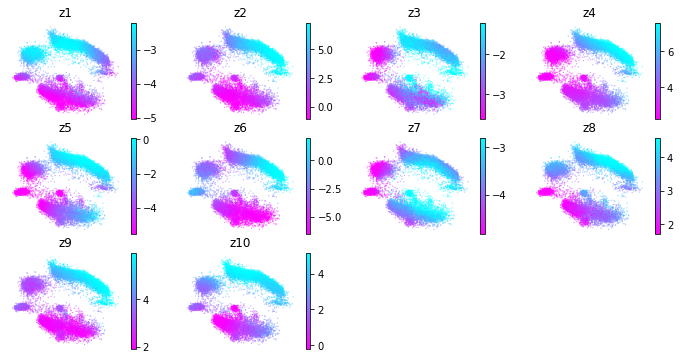

In [41]:
fig,ax = plt.subplots(3,4,figsize=(12,6))
for i in range(10):
    ax0=ax[i//4][i%4].scatter(ad.obsm["decipher_v_corrected"][:,0],ad.obsm["decipher_v_corrected"][:,1],
               c=ad.obsm["decipher_z_corrected"][:,i],rasterized=True,
               s=.05,cmap='cool_r',vmax=np.percentile(ad.obsm["decipher_z_corrected"][:,i],90),
                             vmin=np.percentile(ad.obsm["decipher_z_corrected"][:,i],10))
    ax[i//4][i%4].set_axis_off()
    ax[i//4][i%4].set_title("z"+str(i+1))
    fig.colorbar(ax0, ax=ax[i//4][i%4], orientation='vertical')
ax[2][2].set_axis_off()
ax[2][3].set_axis_off()
plt.savefig("2b.pdf")

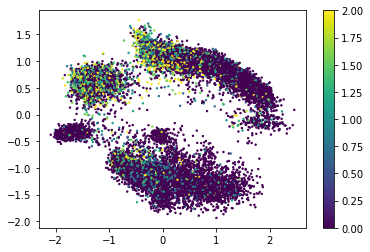

In [174]:
plt.scatter(ad.obsm["decipher_v_corrected"][:,0],ad.obsm["decipher_v_corrected"][:,1],
               c=ad.to_df()["HOXA9"],rasterized=True,
           s=2, vmax=2)
plt.colorbar()

In [22]:
from scipy import interpolate
from scipy import ndimage
def make_bins(bin_size, increment, start, stop):
    i=start
    bins=[]
    while i+bin_size<=stop:
        bins.append([i,i+bin_size])
        i+=increment
    return bins

def gaussian_smooth(x, bin_means):
    x_sm = np.mean(x,axis=1)
    y_sm = np.asarray(bin_means)

    sigma = 2
    x_g1d = ndimage.gaussian_filter1d(x_sm, sigma)
    y_g1d = ndimage.gaussian_filter1d(y_sm, sigma)

    return x_g1d, y_g1d

In [23]:
data = ad.obs["NPM1 mutation vs wild type"]

In [24]:
max(data)

0.9999999999666667

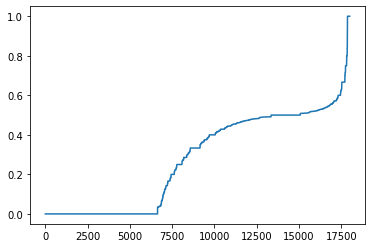

In [25]:
plt.plot(np.sort(data))

In [26]:
data = ad.obs["NPM1 mutation vs wild type"]
binarize = []
for i in data:
    if i>.4:
        binarize.append(1)
    else:
        binarize.append(0)

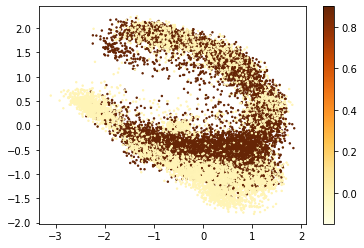

In [27]:
randomize=np.arange(ad.shape[0])
np.random.shuffle(randomize)
plt.scatter(ad.obsm["decipher_v_corrected"][:,0][randomize],ad.obsm["decipher_v_corrected"][:,1][randomize],
               c=np.asarray(binarize)[randomize],rasterized=True,
           s=2, cmap="YlOrBr",vmin=-.15,vmax=.9)
plt.colorbar()

In [28]:
data = binarize
x=ad.obsm["decipher_v_corrected"][:,1]
bins = make_bins(.5,.05, min(x), max(x))
mut_counts = []
wt_counts = []
for i in range(len(bins)):
    mut = 0
    wt = 0
    for t in range(ad.shape[0]):
        if x[t]>=bins[i][0] and x[t]<bins[i][1]:
            if data[t]==1:
                mut+=1
            else:
                wt+=1
            
    mut_counts.append(mut)
    wt_counts.append(wt)

In [29]:
x,mut = gaussian_smooth(bins, mut_counts)

In [30]:
x,wt = gaussian_smooth(bins, wt_counts)

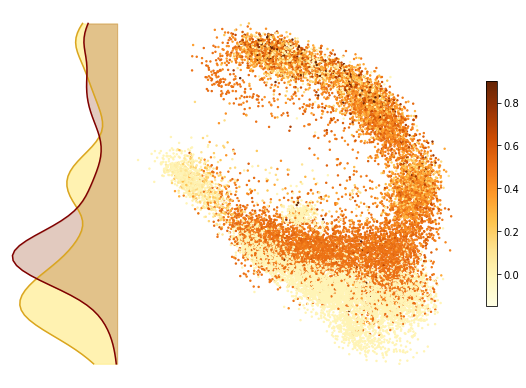

In [31]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left + .2, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

v=np.linspace(.3,.95)


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax0 = ax_scatter.scatter(ad.obsm["decipher_v_corrected"][:,0][randomize],ad.obsm["decipher_v_corrected"][:,1][randomize],
                  c=ad.obs["NPM1 mutation vs wild type"][randomize],rasterized=True,
           s=2, cmap="YlOrBr",vmin=-.15,vmax=.9)

fig.colorbar(ax0, ax=ax_scatter, orientation='vertical',fraction=.03)

ax_histy.plot(wt,x,c="goldenrod")
ax_histy.fill_betweenx(x,wt,color='gold',alpha=.3)

ax_histy.plot(mut,x,c="maroon")
ax_histy.fill_betweenx(x,mut,color='sienna',alpha=.3)

ax_histy.invert_xaxis()
ax_histy.set_axis_off()
ax_scatter.set_axis_off()
plt.savefig("mut_distributions_AML3.pdf")